## Installs

In [ ]:
!pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 12.4 MB/s eta 0:00:00


## Imports

In [ ]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import Predictive
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import Adam
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
import time
pyro.clear_param_store()

## Bayesian Neural Network

In [ ]:
class BNN(PyroModule):
  def __init__(self, inp_dim=1, n_layers=2, out_dim=1, hid_dim=10, pri_scl=5., activ="tanh", reshape = True):
    super().__init__()
    self.activation=nn.Tanh()
    if(activ=="relu"):
      self.activation = nn.ReLU()

    self.reshape = reshape

    self.l_sz_list = []
    self.l_sz_list.append(inp_dim)
    for i in range(n_layers):
      self.l_sz_list.append(hid_dim)

    self.l_sz_list.append(out_dim)
    # layer info
    self.layer_configs = []
    for i in range(1, len(self.l_sz_list)):
      self.layer_configs.append(PyroModule[nn.Linear](self.l_sz_list[i-1], self.l_sz_list[i]))

    self.layers= PyroModule[torch.nn.ModuleList](self.layer_configs)

    for index, layer in enumerate(self.layers):
      layer.weight = PyroSample(dist.Normal(0., pri_scl*np.sqrt(2 / self.l_sz_list[index])).expand([self.l_sz_list[index + 1], self.l_sz_list[index]]).to_event(2))
      layer.bias = PyroSample(dist.Normal(0., pri_scl).expand([self.l_sz_list[index + 1]]).to_event(1))

  def forward(self, x, y=None):
    if self.reshape is True:
      x = x.reshape(-1, 1)
    x = self.activation(self.layers[0](x))
    for i in range(1, len(self.layers)-1):
      x = self.activation(self.layers[i](x))

    mu = self.layers[-1](x).squeeze()
    sigma = pyro.sample("sigma", dist.Gamma(.5, 1)) # for noise

    # for sampling
    with pyro.plate("data", x.shape[0]):  # pyro plate is a context manager for handling collection of data points
      obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)

    return mu

## Plotter

In [ ]:
def plot_data(preds, x_test, x_obs, y_obs, x_true, y_true):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    #setting the plot configs
    fig, ax = plt.subplots(figsize=(10,5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]

    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observed values")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#FF0000", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#FF7F7F', zorder=5)

    plt.legend(loc=4, fontsize=16, frameon=False)

## Data Generation
The function considered in this case is: $y = x + sin(\frac{\pi}{2}x) + sin(\pi x)$.

For this the samples ($x$) are randomly sampled from uniform distribution and corresponding $y$'s are computed after introducing some random noise (for $x\_obs$ and $y\_obs$).

In [ ]:
np.random.seed(int(time.time())) # random seed

# sampling observations
x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(0.5 * np.pi * (x_obs + noise)) + 0.3 * np.sin(np.pi * (x_obs + noise)) + noise

# sampling the true points
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(0.5 * np.pi * x_true) + 0.3 * np.sin(np.pi * x_true)

## Model Training

In [ ]:
x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

model = BNN(hid_dim=10, n_layers=5, pri_scl=5.)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

## Predictions

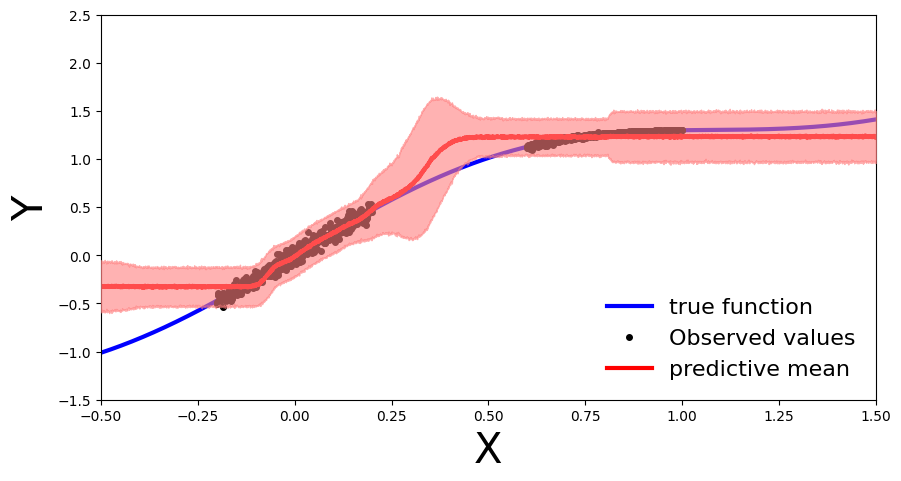

In [ ]:
pred_model = Predictive(model=model, guide=mean_field_guide, num_samples=500)
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = pred_model(x_test)
plot_data(preds, x_test, x_obs, y_obs, x_true, y_true)

## Testing on publicly available datasets
(i) Experience-Salary Dataset

<ul>
<b>Input:</b>
<li><i>Experience - in months</i></li>

<b>Output:</b>
<li><i>Salary - in thousands of $</i></li>
</ul>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('./experience_salary.csv')
data

,exp(in months),salary(in thousands)
0,18.290293,16.521825
1,17.023407,11.666234
2,26.343613,23.167255
3,19.105834,20.877145
4,27.742516,23.166236
...,...,...
995,22.161741,24.666502
996,32.266497,24.160270
997,17.039030,19.903797
998,25.222124,21.974413


##Test-Train Split(25 - 75)

In [ ]:
x = data["exp(in months)"]
y = data["salary(in thousands)"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=int((time.time())%1000),  test_size=0.25,  shuffle=True)

## Training the model

In [ ]:
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()

model1 = BNN(hid_dim=10, n_layers=5, pri_scl=5.)
pyro.set_rng_seed(int(time.time()))
mean_field_guide1 = AutoDiagonalNormal(model1)
optimizer1 = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model1, mean_field_guide1, optimizer1, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 10000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

##Testing

In [ ]:
pred_model1 = Predictive(model=model1, guide=mean_field_guide1, num_samples=500)
x_test_tensor =torch.from_numpy(x_test.to_numpy()).float()
y_test_arr = y_test.to_numpy()
preds = pred_model1(x_test_tensor)
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
mse = 0.0
for i in range(len(y_pred)):
  mse += (y_pred[i]-y_test_arr[i])**2

mse /= len(y_pred)
print(f"The mean squared error(mse) is found to be:", mse)

The mean squared error(mse) is found to be: 28.77481949664665


##Plots

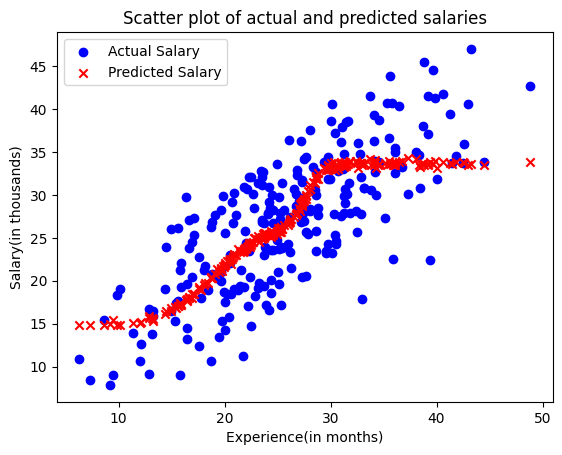

In [ ]:
plt.scatter(x_test, y_test, label = "Actual Salary", color = "blue")
plt.scatter(x_test, y_pred, label = "Predicted Salary", color = "red", marker = "x")
plt.xlabel('Experience(in months)')
plt.ylabel('Salary(in thousands)')
plt.title('Scatter plot of actual and predicted salaries')
plt.legend()

plt.show()

(ii)Admission Prediction Dataset
<ul>
<b>Input:</b>
<li><i>GRE Score: int</i></li>
<li><i>TOEFL Score: int</i></li>
<li><i>University Rating: int (0-5)</i></li>
<li><i>SOP: float</i></li>
<li><i>LOR: float </i></li>
<li><i>CGPA: float </i></li>
<li><i>Research: boolean</i></li>

<b>Output:</b>
<li><i>Chance of Admit: float (percentage)</i></li>
</ul>

In [ ]:
data2 = pd.read_csv('./Admission_Predict.csv')
data2

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...
495,332,108,5,4.5,4.0,9.02,1,0.87
496,337,117,5,5.0,5.0,9.87,1,0.96
497,330,120,5,4.5,5.0,9.56,1,0.93
498,312,103,4,4.0,5.0,8.43,0,0.73


## Normalization of the columns

In [ ]:
from sklearn.preprocessing import MinMaxScaler
columns_to_normalize = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA']
scaler = MinMaxScaler()
data2[columns_to_normalize] = data2[columns_to_normalize].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
data2

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,0.94,0.928571,0.75,0.875,0.875,0.913462,1,0.92
1,0.68,0.535714,0.75,0.750,0.875,0.663462,1,0.76
2,0.52,0.428571,0.50,0.500,0.625,0.384615,1,0.72
3,0.64,0.642857,0.50,0.625,0.375,0.599359,1,0.80
4,0.48,0.392857,0.25,0.250,0.500,0.451923,0,0.65
...,...,...,...,...,...,...,...,...
495,0.84,0.571429,1.00,0.875,0.750,0.711538,1,0.87
496,0.94,0.892857,1.00,1.000,1.000,0.983974,1,0.96
497,0.80,1.000000,1.00,0.875,1.000,0.884615,1,0.93
498,0.44,0.392857,0.75,0.750,1.000,0.522436,0,0.73


## Test-Train Split(25 - 75)

In [ ]:
y = data2['Chance of Admit ']
x = data2.drop(['Chance of Admit ', 'Serial No.'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y , random_state=int((time.time())%1000),  test_size=0.25,  shuffle=True)

## Training the Model

In [ ]:
x_train = torch.from_numpy(x_train.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()

model2 = BNN(inp_dim=7, hid_dim=10, n_layers=5, pri_scl=5., reshape=False)
pyro.set_rng_seed(int(time.time()))
mean_field_guide2 = AutoDiagonalNormal(model2)
optimizer2 = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model2, mean_field_guide2, optimizer2, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 10000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

## Testing

In [ ]:
pred_model2 = Predictive(model=model2, guide=mean_field_guide2, num_samples=500)
x_test_tensor =torch.from_numpy(x_test.to_numpy()).float()
y_test_arr = y_test.to_numpy()
preds = pred_model2(x_test_tensor)
y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
mse = 0.0
for i in range(len(y_pred)):
  mse += (y_pred[i]-y_test_arr[i])**2

mse /= len(y_pred)
print(f"The mean squared error(mse) is found to be:", mse)

The mean squared error(mse) is found to be: 0.021361288318056358
